Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d, lower_triangular, decor_modules
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.train import decor_train
import argparse

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_results(init_model, model, dataloader):

    for batch in dataloader:
        init_model.forward(batch[0].to(device))
        model.forward(batch[0].to(device))
        init_modules = decor_modules(init_model)
        modules = decor_modules(model)
        for i, (imod, mod) in enumerate(zip(init_modules, modules)):
        
            state = imod.decor_state            
            Ci = (state.T @ state) / len(state)
            Ci = Ci.detach().numpy()

            state = mod.decor_state            
            C = (state.T @ state) / len(state)
            C = C.detach().numpy()

            plt.subplot(2, len(modules), i+1)
            plt.title(f'layer {i+1}')
            plt.xlabel('$x_i x_j$')
            plt.hist([lower_triangular(Ci, offset=-1), lower_triangular(C, offset=-1)], bins=30, label=['correlated', 'decorrelated'])
            plt.subplot(2, len(modules), i+1+len(modules))
            plt.hist([np.diagonal(Ci), np.diagonal(C)], bins=30, label=['correlated', 'decorrelated'])
            plt.xlabel('$x_i^2$')
            print(f'layer {i+1} mean covariance before decorrelation: {np.mean(lower_triangular(Ci, offset=-1)):.2f}')
            print(f'layer {i+1} mean covariance after decorrelation: {np.mean(lower_triangular(C, offset=-1)):.2f}')
            print(f'layer {i+1} mean variance before decorrelation: {np.mean(np.diagonal(Ci)):.2f}')
            print(f'layer {i+1} mean variance after decorrelation: {np.mean(np.diagonal(C)):.2f}')
        break
    plt.legend();

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.25)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [13]:
args = argparse.Namespace(lr=0.0, eta=1.0, decor_lr=1e-3, variance=1.0, epochs=10) # FAILS FOR E.G. variance=1.0 at this learning rate

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, variance):
#         super().__init__(DecorLinear(in_features, 100, decor_bias=True, eta=eta, variance=variance),
#                         nn.LeakyReLU(),
#                         DecorLinear(100, 10, decor_bias=True, eta=eta, variance=variance)
#                         )

#     def forward(self, x):
#         return super().forward(x.view(len(x), -1))

class Model(nn.Sequential):
    def __init__(self, in_features, eta, variance):
        super().__init__(Decorrelation(in_features, bias=True, eta=eta, variance=variance),
                        nn.Linear(in_features, out_features=100),
                        nn.LeakyReLU(),
                        Decorrelation(100, bias=True, eta=eta, variance=variance),
                        nn.Linear(100, out_features=10)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

model = Model(784, eta=args.eta, variance=args.variance).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 2.545241	decorrelation loss: 108.187660
epoch 1  	time:0.374 s	bp loss: 2.490352	decorrelation loss: 9.763197
epoch 2  	time:0.362 s	bp loss: 2.465526	decorrelation loss: 1.141219
epoch 3  	time:0.353 s	bp loss: 2.478095	decorrelation loss: 0.920916
epoch 4  	time:0.346 s	bp loss: 2.490503	decorrelation loss: 1.555818
epoch 5  	time:0.390 s	bp loss: 2.509818	decorrelation loss: 3.998651
epoch 6  	time:0.396 s	bp loss: 2.523208	decorrelation loss: 15.151894
epoch 7  	time:0.364 s	bp loss: 2.520735	decorrelation loss: 27.168411
epoch 8  	time:0.355 s	bp loss: 2.549337	decorrelation loss: 70.656868
epoch 9  	time:0.345 s	bp loss: 2.587918	decorrelation loss: 441.702332
epoch 10 	time:0.355 s	bp loss: 2.623953	decorrelation loss: 3874.334229


layer 1 mean covariance before decorrelation: 2.12
layer 1 mean covariance after decorrelation: 0.01
layer 1 mean variance before decorrelation: 3.70
layer 1 mean variance after decorrelation: 1.60
layer 2 mean covariance before decorrelation: 0.15
layer 2 mean covariance after decorrelation: 0.05
layer 2 mean variance before decorrelation: 0.50
layer 2 mean variance after decorrelation: 0.77


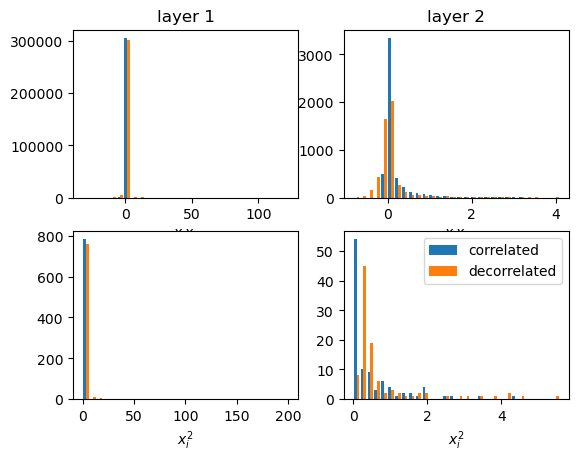

In [14]:
init_model = Model(784, eta=args.eta, variance=args.variance).to(device) # deepcopy does not work
plot_results(init_model, model, train_loader)